In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib notebook

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

#size of training dataset
train_samples = train.shape[0]

In [19]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [81]:
X_train = train[['Pclass','Age','SibSp','Parch','Fare']]
y_train = train[['Survived']]
X_train = X_train.fillna(X_train.mean()) #(method='ffill')
colormap = {0:'firebrick',1:'steelblue'}
colors = y_train.Survived.map(colormap)

In [83]:
from sklearn.preprocessing import MinMaxScaler

# Note the way of scalin (df[df.columns])
# we want to mantain the dataframe (instead of numpy array)
X_train[X_train.columns] = MinMaxScaler().fit_transform(X_train[X_train.columns])

<IPython.core.display.Javascript object>


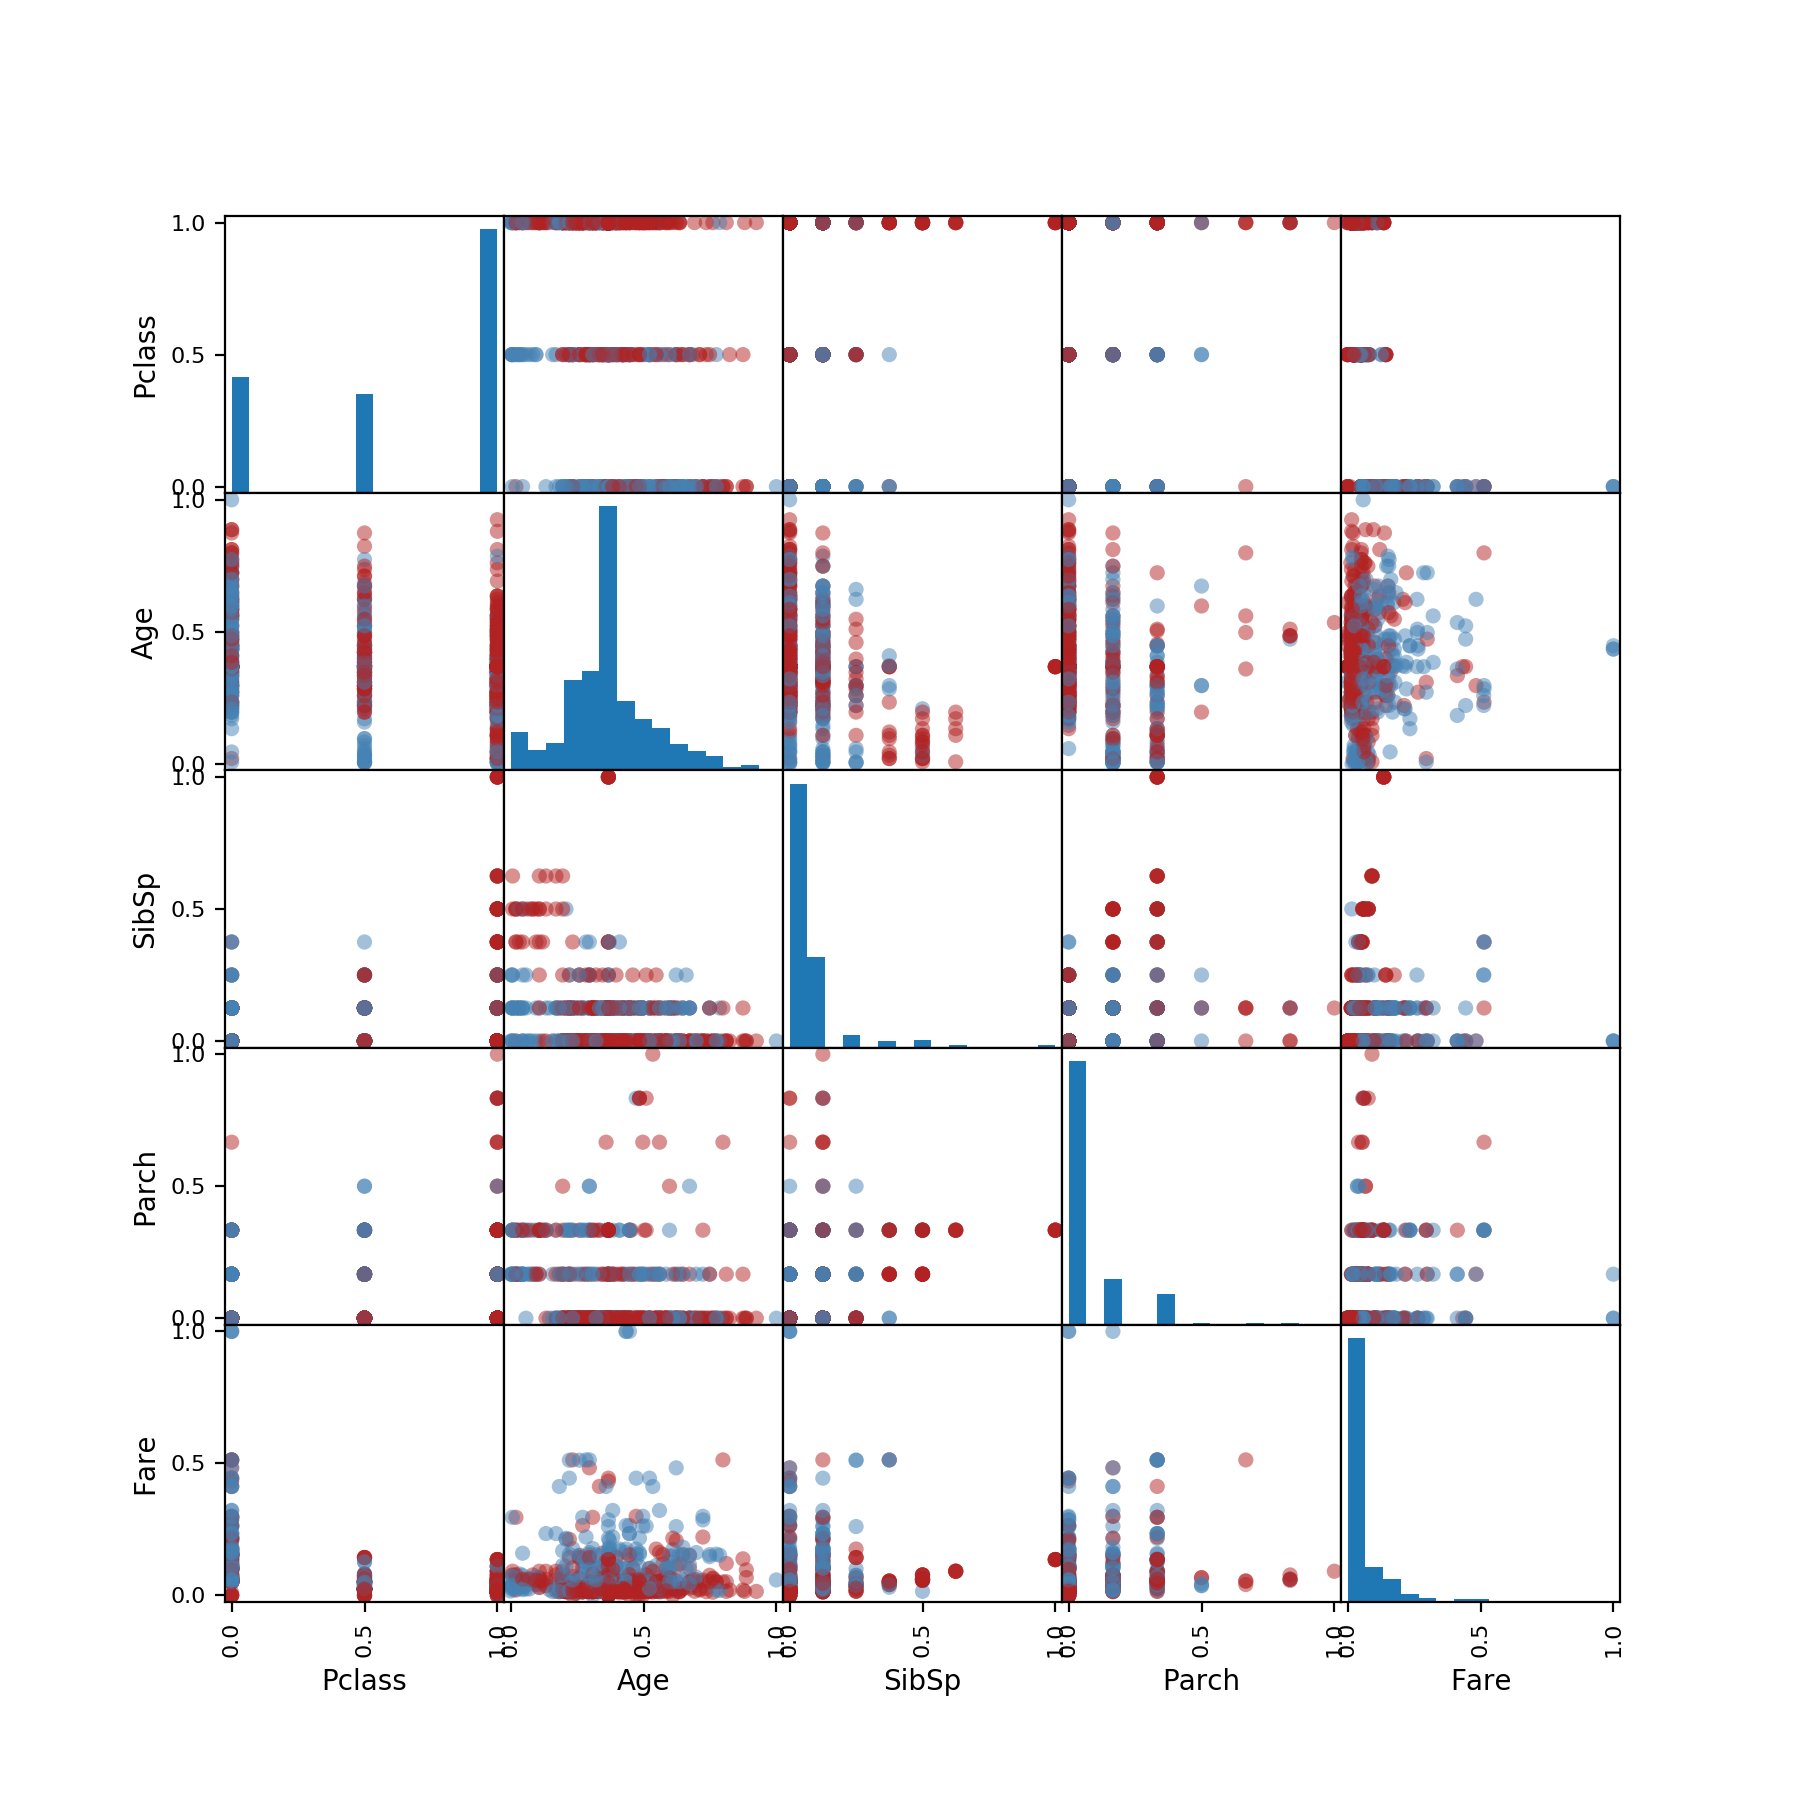

In [84]:
# plotting a scatter matrix
pd.plotting.scatter_matrix(X_train, c=colors, marker = 'o', s=30,
                           hist_kwds={'bins':15}, figsize=(9,9));

